## Monthly data

Psi, SF and MX decompositions for 10 years of 1degree data (output101-110, stored on /scratch/e14)
- total
- mean total
- seasonal climatology, smoothed by 2 months filter
- 2 month filter for 10 years
- script to do 10 daily and daily filters (by year) on gadi

++ we save means of climatology

We don't do analysis of small terms here. This is a direct comparison (same terms) to the 025 degree model.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

2022-12-03 17:36:58,220 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/Analysis/dask-worker-space/worker-pgt2hvgx', purging
2022-12-03 17:36:58,231 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/Analysis/dask-worker-space/worker-gnbkkxck', purging
2022-12-03 17:36:58,243 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/Analysis/dask-worker-space/worker-w9v8dip1', purging
2022-12-03 17:36:58,254 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/Analysis/dask-worker-space/worker-z8_nifz5', purging
2022-12-03 17:36:58,262 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37973,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:35349,Total threads: 2
Dashboard: /proxy/33479/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:44791,


In [3]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/';
xch = 360#2*288
ych = 240#2*216

fgrd   = xr.open_dataset(base + 'output101/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})

base = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101-110_mean/'
fwmass_sc = xr.open_mfdataset(base+'ocean_wmass.ncea.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_sc = xr.open_mfdataset(base+'ocean_month.ncea.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_sc = xr.open_mfdataset(base+'ocean_heat.ncea.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

fwmass_mean = xr.open_mfdataset(base+'ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_mean = xr.open_mfdataset(base+'ocean_month_mean.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_mean = xr.open_mfdataset(base+'ocean_heat_mean.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

In [4]:
%%time
#### load output of monthly data for 10 years (RYF) #### output 101-110
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
nr_outputs = 10    # define number of output files to consider
last_output = 110  # the last output to consider loading in
# ---------------------------------------------------------------------------------- #
a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
s = list(range(0,nr_outputs))
c = [] # empty list which I fill up
d = []
e = []
for i in s: # loop through the number of files I would like
    #c.append(i)
    d.append(i)
    e.append(i)
    # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
    #c[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_wmass.nc' 
    d[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_heat.nc' 
    e[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc' 

# load in data set ----------------------------------------------------------------- #
#fwmass_m = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/20,'xt_ocean':xch/20})
fmonth_m = xr.open_mfdataset(e,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/20,'yu_ocean':ych/20,'xt_ocean':xch/20})


CPU times: user 22.8 s, sys: 978 ms, total: 23.8 s
Wall time: 23.2 s


In [5]:
# load RYF monthly data  for 1 year to get wmass grid
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fwmass_m1 = xr.open_mfdataset(base_msc+'ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})


# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m1,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m1.neutral[1]-fwmass_m1.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})

Define some functions

In [30]:
def running_av_2mos(variable):
    month_length = variable.time.dt.days_in_month
    running_mean = (variable*month_length).roll(time = 1, roll_coords = False)+ (variable*month_length)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    running_mean = running_mean/time_length
    return running_mean


In [54]:
def running_av_2mos_mo(variable):
    month_length = variable.time.dt.days_in_month
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    time_length = time_length/2
    return time_length


In [52]:
def weighted_time_mean_2mo_filter(variable):
    month_length = running_av_2mos_mo(variable.time.dt.days_in_month)
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

In [11]:
def weighted_time_mean(variable):
    month_length = variable.time.dt.days_in_month
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

### COMPUTATION OF TIME MEANS


Here I use the seasonal climatologies of the 10 years of data (calculated using script `/g/data/e14/cy8964/scripts/pbs_sub_1deg_10yr.sh` and then take time mean of them manually using my weighted time mean function, and save them out.

In [13]:
%%time
## correct time means of ocean_wmass.nc

# weighted time average
mean_ty_trans_nrho = weighted_time_mean(fwmass_sc.ty_trans_nrho)

mean_ty_trans_nrho_submeso = weighted_time_mean(fwmass_sc.ty_trans_nrho_submeso)
mean_ty_trans_nrho_gm = weighted_time_mean(fwmass_sc.ty_trans_nrho_gm)
mean_temp_yflux_adv_on_nrho = weighted_time_mean(fwmass_sc.temp_yflux_adv_on_nrho)
mean_temp_yflux_submeso_on_nrho = weighted_time_mean(fwmass_sc.temp_yflux_submeso_on_nrho)
mean_temp_yflux_gm_on_nrho = weighted_time_mean(fwmass_sc.temp_yflux_gm_on_nrho)
mean_temp_yflux_ndiffuse_on_nrho = weighted_time_mean(fwmass_sc.temp_yflux_ndiffuse_on_nrho)

mean_neutral_diffusion_on_nrho_temp = weighted_time_mean(fwmass_sc.neutral_diffusion_on_nrho_temp)
mean_neutral_gm_on_nrho_temp = weighted_time_mean(fwmass_sc.neutral_gm_on_nrho_temp)
mean_temp_vdiffuse_k33_on_nrho = weighted_time_mean(fwmass_sc.temp_vdiffuse_k33_on_nrho)
mean_mixdownslope_temp_on_nrho = weighted_time_mean(fwmass_sc.mixdownslope_temp_on_nrho)
mean_temp_sigma_diff_on_nrho = weighted_time_mean(fwmass_sc.temp_sigma_diff_on_nrho)
mean_temp_eta_smooth_on_nrho = weighted_time_mean(fwmass_sc.temp_eta_smooth_on_nrho)
mean_temp_rivermix_on_nrho = weighted_time_mean(fwmass_sc.temp_rivermix_on_nrho )
mean_mass_pmepr_on_nrho = weighted_time_mean(fwmass_sc.mass_pmepr_on_nrho)

mean_temp_vdiffuse_sbc_on_nrho = weighted_time_mean(fwmass_sc.temp_vdiffuse_sbc_on_nrho)
mean_sfc_hflux_pme_on_nrho = weighted_time_mean(fwmass_sc.sfc_hflux_pme_on_nrho)
mean_frazil_on_nrho = weighted_time_mean(fwmass_sc.frazil_on_nrho)
mean_sw_heat_on_nrho = weighted_time_mean(fwmass_sc.sw_heat_on_nrho)
mean_temp_vdiffuse_diff_cbt_on_nrho = weighted_time_mean(fwmass_sc.temp_vdiffuse_diff_cbt_on_nrho)
mean_temp_nonlocal_KPP_on_nrho = weighted_time_mean(fwmass_sc.temp_nonlocal_KPP_on_nrho)

mean_temp_vdiffuse_diff_cbt_kppish_on_nrho = weighted_time_mean(fwmass_sc.temp_vdiffuse_diff_cbt_kppish_on_nrho)
mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho = weighted_time_mean(fwmass_sc.temp_vdiffuse_diff_cbt_kppicon_on_nrho)
mean_vdiffuse_diff_cbt_kppbl_on_nrho = weighted_time_mean(fwmass_sc.temp_vdiffuse_diff_cbt_kppbl_on_nrho)
mean_temp_vdiffuse_diff_cbt_wave_on_nrho = weighted_time_mean(fwmass_sc.temp_vdiffuse_diff_cbt_wave_on_nrho)
mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho = weighted_time_mean(fwmass_sc.temp_vdiffuse_diff_cbt_kppdd_on_nrho)

# load
mean_ty_trans_nrho.load()
mean_temp_vdiffuse_sbc_on_nrho.load()
mean_sfc_hflux_pme_on_nrho.load()
mean_frazil_on_nrho.load()
mean_sw_heat_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_on_nrho.load()
mean_temp_nonlocal_KPP_on_nrho.load()
mean_sw_heat_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_kppish_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho.load()
mean_vdiffuse_diff_cbt_kppbl_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_wave_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho.load()

mean_ty_trans_nrho_submeso.load()
mean_ty_trans_nrho_gm.load()
mean_temp_yflux_adv_on_nrho.load()
mean_temp_yflux_submeso_on_nrho.load()
mean_temp_yflux_gm_on_nrho.load()
mean_temp_yflux_ndiffuse_on_nrho.load()

mean_neutral_diffusion_on_nrho_temp.load()
mean_neutral_gm_on_nrho_temp.load()
mean_temp_vdiffuse_k33_on_nrho.load()
mean_mixdownslope_temp_on_nrho.load()
mean_temp_sigma_diff_on_nrho.load()
mean_temp_eta_smooth_on_nrho.load()
mean_temp_rivermix_on_nrho.load()
mean_mass_pmepr_on_nrho.load()

CPU times: user 27.6 s, sys: 8.63 s, total: 36.2 s
Wall time: 4min 22s


<xarray.DataArray (neutral: 74, grid_yt_ocean: 300, grid_xt_ocean: 360)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * grid_xt_ocean  (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5
  * neutral        (neutral) float64 -2.75 -2.25 -1.75 ... 32.75 33.25 33.75
  * grid_yt_ocean  (grid_yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77

In [16]:
# save to ncfile
ds = xr.Dataset({'ty_trans_nrho': mean_ty_trans_nrho, 'temp_vdiffuse_sbc_on_nrho': mean_temp_vdiffuse_sbc_on_nrho, 
                 'sfc_hflux_pme_on_nrho':mean_sfc_hflux_pme_on_nrho, 'frazil_on_nrho':mean_frazil_on_nrho,
                 'sw_heat_on_nrho':mean_sw_heat_on_nrho,'temp_vdiffuse_diff_cbt_on_nrho':mean_temp_vdiffuse_diff_cbt_on_nrho,
                 'temp_nonlocal_KPP_on_nrho':mean_temp_nonlocal_KPP_on_nrho,'temp_vdiffuse_diff_cbt_kppdd_on_nrho':mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho,
                 'sw_heat_on_nrho':mean_sw_heat_on_nrho,'temp_vdiffuse_diff_cbt_kppish_on_nrho':mean_temp_vdiffuse_diff_cbt_kppish_on_nrho,
                 'temp_vdiffuse_diff_cbt_kppicon_on_nrho':mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho,'temp_vdiffuse_diff_cbt_kppbl_on_nrho':mean_vdiffuse_diff_cbt_kppbl_on_nrho,
                 'temp_vdiffuse_diff_cbt_wave_on_nrho':mean_temp_vdiffuse_diff_cbt_wave_on_nrho,
                 'ty_trans_nrho_submeso':mean_ty_trans_nrho_submeso,
                 'ty_trans_nrho_gm':mean_ty_trans_nrho_gm,
                 'temp_yflux_adv_on_nrho':mean_temp_yflux_adv_on_nrho,
                 'temp_yflux_submeso_on_nrho':mean_temp_yflux_submeso_on_nrho,
                 'temp_yflux_gm_on_nrho':mean_temp_yflux_gm_on_nrho,
                 'temp_yflux_ndiffuse_on_nrho':mean_temp_yflux_ndiffuse_on_nrho,
                 'neutral_diffusion_on_nrho_temp':mean_neutral_diffusion_on_nrho_temp,
                 'neutral_gm_on_nrho_temp':mean_neutral_gm_on_nrho_temp,
                 'temp_vdiffuse_k33_on_nrho':mean_temp_vdiffuse_k33_on_nrho,
                 'mixdownslope_temp_on_nrho':mean_mixdownslope_temp_on_nrho,
                 'temp_sigma_diff_on_nrho':mean_temp_sigma_diff_on_nrho,
                 'temp_eta_smooth_on_nrho':mean_temp_eta_smooth_on_nrho,
                 'temp_rivermix_on_nrho':mean_temp_rivermix_on_nrho,
                 'mass_pmepr_on_nrho':mean_mass_pmepr_on_nrho})
                 
ds.to_netcdf('/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101-110_mean/ocean_wmass_mean.nc', 
         encoding={'ty_trans_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'ty_trans_nrho_submeso': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'ty_trans_nrho_gm': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_yflux_adv_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_yflux_submeso_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_yflux_gm_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_yflux_ndiffuse_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'neutral_diffusion_on_nrho_temp': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'neutral_gm_on_nrho_temp': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_k33_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'mixdownslope_temp_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_sigma_diff_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_eta_smooth_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_rivermix_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'mass_pmepr_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5}})


In [18]:
%%time
## correct time means of ocean_heat.nc

# weighted time average
mean_temp_vdiffuse_sbc = weighted_time_mean(fheat_sc.temp_vdiffuse_sbc)
mean_sfc_hflux_pme = weighted_time_mean(fheat_sc.sfc_hflux_pme)
mean_frazil_3d = weighted_time_mean(fheat_sc.frazil_3d)
mean_sw_heat = weighted_time_mean(fheat_sc.sw_heat)
mean_temp_vdiffuse_diff_cbt = weighted_time_mean(fheat_sc.temp_vdiffuse_diff_cbt)
mean_temp_nonlocal_KPP = weighted_time_mean(fheat_sc.temp_nonlocal_KPP)

mean_temp_vdiffuse_diff_cbt_kppish = weighted_time_mean(fheat_sc.temp_vdiffuse_diff_cbt_kppish)
mean_temp_vdiffuse_diff_cbt_kppicon = weighted_time_mean(fheat_sc.temp_vdiffuse_diff_cbt_kppicon)
mean_vdiffuse_diff_cbt_kppbl = weighted_time_mean(fheat_sc.temp_vdiffuse_diff_cbt_kppbl)
mean_temp_vdiffuse_diff_cbt_wave = weighted_time_mean(fheat_sc.temp_vdiffuse_diff_cbt_wave)
mean_temp_vdiffuse_diff_cbt_kppdd = weighted_time_mean(fheat_sc.temp_vdiffuse_diff_cbt_kppdd)

mean_neutral_diffusion_temp = weighted_time_mean(fheat_sc.neutral_diffusion_temp)
mean_neutral_gm_temp = weighted_time_mean(fheat_sc.neutral_gm_temp)
mean_temp_vdiffuse_k33 = weighted_time_mean(fheat_sc.temp_vdiffuse_k33)
mean_mixdownslope_temp = weighted_time_mean(fheat_sc.mixdownslope_temp)
mean_temp_sigma_diff = weighted_time_mean(fheat_sc.temp_sigma_diff)
mean_temp_eta_smooth = weighted_time_mean(fheat_sc.temp_eta_smooth)
mean_temp_rivermix = weighted_time_mean(fheat_sc.temp_rivermix)



# load
mean_temp_vdiffuse_sbc.load()
mean_sfc_hflux_pme.load()
mean_frazil_3d.load()
mean_sw_heat.load()
mean_temp_vdiffuse_diff_cbt.load()
mean_temp_nonlocal_KPP.load()
mean_temp_vdiffuse_diff_cbt_kppish.load()
mean_temp_vdiffuse_diff_cbt_kppicon.load()
mean_vdiffuse_diff_cbt_kppbl.load()
mean_temp_vdiffuse_diff_cbt_wave.load()
mean_temp_vdiffuse_diff_cbt_kppdd.load()
mean_neutral_diffusion_temp.load()
mean_neutral_gm_temp.load()
mean_temp_vdiffuse_k33.load()
mean_mixdownslope_temp.load()
mean_temp_sigma_diff.load()
mean_temp_eta_smooth.load()
mean_temp_rivermix.load()

# save to ncfile
ds = xr.Dataset({'temp_vdiffuse_sbc': mean_temp_vdiffuse_sbc, 
                 'sfc_hflux_pme':mean_sfc_hflux_pme, 'frazil_3d':mean_frazil_3d,
                 'sw_heat':mean_sw_heat,'temp_vdiffuse_diff_cbt':mean_temp_vdiffuse_diff_cbt,
                 'temp_nonlocal_KPP':mean_temp_nonlocal_KPP,'temp_vdiffuse_diff_cbt_kppdd':mean_temp_vdiffuse_diff_cbt_kppdd,
                 'temp_vdiffuse_diff_cbt_kppish':mean_temp_vdiffuse_diff_cbt_kppish,
                 'temp_vdiffuse_diff_cbt_kppicon':mean_temp_vdiffuse_diff_cbt_kppicon,'temp_vdiffuse_diff_cbt_kppbl':mean_vdiffuse_diff_cbt_kppbl,
                 'temp_vdiffuse_diff_cbt_wave':mean_temp_vdiffuse_diff_cbt_wave,
                 'neutral_diffusion_temp':mean_neutral_diffusion_temp,
                 'neutral_gm_temp':mean_neutral_gm_temp,
                 'temp_vdiffuse_k33':mean_temp_vdiffuse_k33,
                 'mixdownslope_temp':mean_mixdownslope_temp,
                 'temp_sigma_diff':mean_temp_sigma_diff,
                 'temp_eta_smooth':mean_temp_eta_smooth,
                 'temp_rivermix':mean_temp_rivermix})

                 
ds.to_netcdf('/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101-110_mean/ocean_heat_mean.nc', 
         encoding={'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'neutral_diffusion_temp': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'neutral_gm_temp': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_k33': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'mixdownslope_temp': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_sigma_diff': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_eta_smooth': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_rivermix': {'shuffle': True, 'zlib': True, 'complevel': 5}})



CPU times: user 33.2 s, sys: 3.65 s, total: 36.9 s
Wall time: 1min 43s


In [20]:
%%time
## correct time means of ocean_month.nc

# weighted time average
mean_temp = weighted_time_mean(fmonth_sc.temp)
mean_ty_trans = weighted_time_mean(fmonth_sc.ty_trans)
mean_ty_trans_submeso = weighted_time_mean(fmonth_sc.ty_trans_submeso)
mean_ty_trans_gm = weighted_time_mean(fmonth_sc.ty_trans_gm)
mean_temp_yflux_adv = weighted_time_mean(fmonth_sc.temp_yflux_adv)
mean_temp_yflux_submeso = weighted_time_mean(fmonth_sc.temp_yflux_submeso)
mean_temp_yflux_gm = weighted_time_mean(fmonth_sc.temp_yflux_gm)
mean_temp_yflux_ndiffuse = weighted_time_mean(fmonth_sc.temp_yflux_ndiffuse)
mean_pme_river = weighted_time_mean(fmonth_sc.pme_river)

# load
mean_temp.load()
mean_ty_trans.load()
mean_ty_trans_submeso.load()
mean_ty_trans_gm.load()
mean_temp_yflux_adv.load()
mean_temp_yflux_submeso.load()
mean_temp_yflux_gm.load()
mean_temp_yflux_ndiffuse.load()
mean_pme_river.load()

# save to ncfile
ds = xr.Dataset({'temp': mean_temp, 'ty_trans':mean_ty_trans, 
                 'ty_trans_submeso':mean_ty_trans_submeso,
                 'ty_trans_gm':mean_ty_trans_gm,
                 'temp_yflux_adv':mean_temp_yflux_adv,
                 'temp_yflux_submeso':mean_temp_yflux_submeso,
                 'temp_yflux_gm':mean_temp_yflux_gm,
                 'temp_yflux_ndiffuse':mean_temp_yflux_ndiffuse,
                 'pme_river':mean_pme_river})
                 
ds.to_netcdf('/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101-110_mean/ocean_month_mean.nc', 
         encoding={'temp': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'ty_trans': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'ty_trans_submeso': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'ty_trans_gm': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_yflux_adv': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_yflux_submeso': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_yflux_gm': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_yflux_ndiffuse': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'pme_river': {'shuffle': True, 'zlib': True, 'complevel': 5} })

CPU times: user 17.6 s, sys: 1.53 s, total: 19.2 s
Wall time: 31.8 s


### Analysis/Decomposition - Continue Here:

In [26]:
obj, obj2 = xr.broadcast(fheat_m.sfc_hflux_pme,fheat_m.temp_vdiffuse_sbc)
sfc_hflux_pme_m = obj.where(fheat_m.st_ocean==fheat_m.st_ocean[0],other=0.)
fheat_m["sfc_hflux_pme_m"]=sfc_hflux_pme_m
fheat_m["SF_cv"] = fheat_m.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_m + \
                      fheat_m.frazil_3d + \
                      fheat_m.sw_heat# + \
#                      fheat_m.temp_rivermix
fheat_m["MX_cv"] = fheat_m.temp_vdiffuse_diff_cbt + \
                      fheat_m.temp_nonlocal_KPP 
# Group SF and MX terms for sc data:

obj, obj2 = xr.broadcast(fheat_sc.sfc_hflux_pme,fheat_sc.temp_vdiffuse_sbc)
sfc_hflux_pme_sc = obj.where(fheat_sc.st_ocean==fheat_sc.st_ocean[0],other=0.)
fheat_sc["sfc_hflux_pme_sc"]=sfc_hflux_pme_sc
fheat_sc["MX_cv"] = fheat_sc.temp_vdiffuse_diff_cbt + \
                      fheat_sc.temp_nonlocal_KPP 
fheat_sc["SF_cv"] = fheat_sc.temp_vdiffuse_sbc + \
                      fheat_sc.sw_heat + \
                      fheat_sc.frazil_3d + \
                      sfc_hflux_pme_sc 
#                      fheat_sc.temp_rivermix
fwmass_sc["MX_cv"] = fwmass_sc.temp_vdiffuse_diff_cbt_on_nrho + \
                      fwmass_sc.temp_nonlocal_KPP_on_nrho 
fwmass_sc["SF_cv"] = fwmass_sc.temp_vdiffuse_sbc_on_nrho + \
                      fwmass_sc.sw_heat_on_nrho + \
                      fwmass_sc.sfc_hflux_pme_on_nrho + \
                      fwmass_sc.frazil_on_nrho
# Group mean SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho #+ \
                       #fwmass_mean.temp_rivermix_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)
fheat_mean["sfc_hflux_pme_mean"]=sfc_hflux_pme_mean
fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \
#                      fheat_mean.temp_rivermix
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP


Calculate running 2 month means and save them in same DataSets for ease of use with xgcm.
Binning done with xhistogram to capture partial cells.

In [28]:
tbins = fwmass_m1.neutralrho_edges.values

In [34]:
# calculate a running mean of 2 months of ty_trans_nrho, temp and ty_trans and add them back into datasets
fmonth_m['temp_2mo'] = running_av_2mos(fmonth_m.temp)
fmonth_m['ty_trans_2mo'] = running_av_2mos(fmonth_m.ty_trans)

# temperature binning of 2 month running average of both temp and ty_trans:
temp_u_mean = gridmn.interp(temp_2mo,'y',boundary='extend')-273.15
ty_trans_nrho_mean_2mo = histogram(temp_u_mean, bins=[tbins], dim = ['st_ocean'],weights=ty_trans_2mo).rename({temp_u_mean.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# temperature binning of 10 year
temp_u_mean_tot = gridmn.interp(fmonth_mean.temp,'y',boundary='extend')-273.15
ty_trans_nrho_mean_10yr = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.ty_trans).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# calculate a running mean of 2 months of seasonal climatology
fwmass_sc['ty_trans_nrho_2mo'] = running_av_2mos(fwmass_sc.ty_trans_nrho)
fmonth_sc['temp_2mo'] = running_av_2mos(fmonth_sc.temp)
fmonth_sc['ty_trans_2mo'] = running_av_2mos(fmonth_sc.ty_trans)

# temperature binning of 2 month running average of both temp and ty_trans:
temp_u_mean_sc = gridmn.interp(fmonth_sc.temp_2mo,'y',boundary='extend')-273.15
fwmass_sc["ty_trans_nrho_mean_2mo"] = histogram(temp_u_mean_sc, bins=[tbins], dim = ['st_ocean'],weights=fmonth_sc.ty_trans_2mo).rename({temp_u_mean_sc.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})


now do running averages of surface flux and mixing:

In [35]:
# calculate a running mean of 2 months of things
fheat_m['SF_cv_2mo'] = running_av_2mos(fheat_m.SF_cv)
fheat_m['MX_cv_2mo'] = running_av_2mos(fheat_m.MX_cv)

fheat_m['sw_heat_2mo'] = running_av_2mos(fheat_m.sw_heat)
fheat_m['frazil_3d_2mo'] = running_av_2mos(fheat_m.frazil_3d)
fheat_m['temp_vdiffuse_sbc_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_sbc)
fheat_m['sfc_hflux_pme_2mo'] = running_av_2mos(fheat_m.sfc_hflux_pme_m)
fheat_m['temp_nonlocal_KPP_2mo'] = running_av_2mos(fheat_m.temp_nonlocal_KPP)
fheat_m['temp_vdiffuse_diff_cbt_kppish_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppish)
fheat_m['temp_vdiffuse_diff_cbt_kppicon_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppicon)
fheat_m['temp_vdiffuse_diff_cbt_kppbl_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppbl)
fheat_m['temp_vdiffuse_diff_cbt_kppdd_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppdd)
fheat_m['temp_vdiffuse_diff_cbt_wave_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_wave)

##----##
# same for seasonal climatology

# calculate a running mean of 2 months of things
fheat_sc['SF_cv_2mo'] = running_av_2mos(fheat_sc.SF_cv)
fheat_sc['MX_cv_2mo'] = running_av_2mos(fheat_sc.MX_cv)

fheat_sc['sw_heat_2mo'] = running_av_2mos(fheat_sc.sw_heat)
fheat_sc['frazil_3d_2mo'] = running_av_2mos(fheat_sc.frazil_3d)
fheat_sc['temp_vdiffuse_sbc_2mo'] = running_av_2mos(fheat_sc.temp_vdiffuse_sbc)
fheat_sc['sfc_hflux_pme_2mo'] = running_av_2mos(fheat_sc.sfc_hflux_pme_sc)
fheat_sc['temp_nonlocal_KPP_2mo'] = running_av_2mos(fheat_sc.temp_nonlocal_KPP)
fheat_sc['temp_vdiffuse_diff_cbt_kppish_2mo'] = running_av_2mos(fheat_sc.temp_vdiffuse_diff_cbt_kppish)
fheat_sc['temp_vdiffuse_diff_cbt_kppicon_2mo'] = running_av_2mos(fheat_sc.temp_vdiffuse_diff_cbt_kppicon)
fheat_sc['temp_vdiffuse_diff_cbt_kppbl_2mo'] = running_av_2mos(fheat_sc.temp_vdiffuse_diff_cbt_kppbl)
fheat_sc['temp_vdiffuse_diff_cbt_kppdd_2mo'] = running_av_2mos(fheat_sc.temp_vdiffuse_diff_cbt_kppdd)
fheat_sc['temp_vdiffuse_diff_cbt_wave_2mo'] = running_av_2mos(fheat_sc.temp_vdiffuse_diff_cbt_wave)
#temp_nonlocal_KPP by residual



Bin two month binned things into temperature space

In [36]:
# temperature binning of 2 month mean
# SF and MX:
#temp_u_mean = gridmn.interp(fmonth_m.temp_2mo,'y',boundary='extend')-273.15
SF_cv_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.SF_cv_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
MX_cv_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.MX_cv_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
sw_heat_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.sw_heat_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
frazil_3d_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.frazil_3d_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
temp_vdiffuse_sbc_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_sbc_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
sfc_hflux_pme_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.sfc_hflux_pme_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
temp_nonlocal_KPP_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_nonlocal_KPP_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
temp_vdiffuse_diff_cbt_kppish_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppish_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
temp_vdiffuse_diff_cbt_kppicon_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppicon_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
temp_vdiffuse_diff_cbt_kppbl_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppbl_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
temp_vdiffuse_diff_cbt_kppdd_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppdd_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
temp_vdiffuse_diff_cbt_wave_mean_2mo = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_wave_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})



Bin 2 month smoothed climatology into temp space

In [37]:
# temperature binning of 2 month mean
# SF and MX:
#temp_u_mean = gridmn.interp(fmonth_m.temp_2mo,'y',boundary='extend')-273.15
fwmass_sc["SF_cv_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.SF_cv_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["MX_cv_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.MX_cv_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["sw_heat_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.sw_heat_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["frazil_3d_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.frazil_3d_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["temp_vdiffuse_sbc_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.temp_vdiffuse_sbc_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["sfc_hflux_pme_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.sfc_hflux_pme_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["temp_nonlocal_KPP_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.temp_nonlocal_KPP_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["temp_vdiffuse_diff_cbt_kppish_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.temp_vdiffuse_diff_cbt_kppish_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["temp_vdiffuse_diff_cbt_kppicon_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.temp_vdiffuse_diff_cbt_kppicon_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["temp_vdiffuse_diff_cbt_kppbl_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.temp_vdiffuse_diff_cbt_kppbl_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["temp_vdiffuse_diff_cbt_kppdd_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.temp_vdiffuse_diff_cbt_kppdd_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["temp_vdiffuse_diff_cbt_wave_mean_2mo"] = histogram(fmonth_sc.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_sc.temp_vdiffuse_diff_cbt_wave_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})



In [39]:
# SF and MX: (use xhistogram because seems to have issues with xgcm)
tbins = fwmass_m1.neutralrho_edges.values
# apply histogram binning to st_ocean dimension
fwmass_mean["SF_cv_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.SF_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["MX_cv_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.MX_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["sw_heat_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.sw_heat).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["frazil_3d_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.frazil_3d).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_sbc_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_sbc).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["sfc_hflux_pme_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.sfc_hflux_pme_mean).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_nonlocal_KPP_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_nonlocal_KPP).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppish_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppish).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppicon_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppicon).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppbl_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppbl).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppdd_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppdd).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_wave_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_wave).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

Calculate surface forcing, vertical mixing and streamfunction terms

**WITHOUT .sum('grid_xt_ocean')..../dy** so that I can make spatial maps AND zonal means

In [40]:
# True surface forcing and vertical mixing:
SF = -gridwm.cumsum((fwmass_mean.SF_cv*area), 'T',boundary="fill",fill_value=0)
MX = -gridwm.cumsum((fwmass_mean.MX_cv*area), 'T',boundary="fill",fill_value=0)

sw_heat = -gridwm.cumsum((fwmass_mean.sw_heat_on_nrho*area), 'T',boundary="fill",fill_value=0)
frazil_3d = -gridwm.cumsum((fwmass_mean.frazil_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_sbc_on_nrho*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme = -gridwm.cumsum((fwmass_mean.sfc_hflux_pme_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP = -gridwm.cumsum((fwmass_mean.temp_nonlocal_KPP_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppish_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppicon_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppbl_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppdd_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_wave_on_nrho*area), 'T',boundary="fill",fill_value=0)

# Same for 2 mo time mean:
SF_mean_2mo = -gridwm.cumsum((SF_cv_mean_2mo*area), 'T',boundary="fill",fill_value=0)
MX_mean_2mo = -gridwm.cumsum((MX_cv_mean_2mo*area), 'T',boundary="fill",fill_value=0)

sw_heat_mean_2mo = -gridwm.cumsum((sw_heat_mean_2mo*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_2mo = -gridwm.cumsum((frazil_3d_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_2mo = -gridwm.cumsum((temp_vdiffuse_sbc_mean_2mo*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme_mean_2mo  = -gridwm.cumsum((sfc_hflux_pme_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP_mean_2mo  = -gridwm.cumsum((temp_nonlocal_KPP_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_mean_2mo = -gridwm.cumsum((temp_vdiffuse_diff_cbt_kppish_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_mean_2mo = -gridwm.cumsum((temp_vdiffuse_diff_cbt_kppicon_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_mean_2mo = -gridwm.cumsum((temp_vdiffuse_diff_cbt_kppbl_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_mean_2mo = -gridwm.cumsum((temp_vdiffuse_diff_cbt_kppdd_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_mean_2mo = -gridwm.cumsum((temp_vdiffuse_diff_cbt_wave_mean_2mo*area), 'T',boundary="fill",fill_value=0)

# # Same for seasonal climatology:
SF_mean_sc = -gridwm.cumsum((fwmass_sc.SF_cv_mean_2mo*area), 'T',boundary="fill",fill_value=0)
MX_mean_sc = -gridwm.cumsum((fwmass_sc.MX_cv_mean_2mo*area), 'T',boundary="fill",fill_value=0)

sw_heat_mean_sc = -gridwm.cumsum((fwmass_sc.sw_heat_mean_2mo*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_sc = -gridwm.cumsum((fwmass_sc.frazil_3d_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_sc = -gridwm.cumsum((fwmass_sc.temp_vdiffuse_sbc_mean_2mo*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme_mean_sc  = -gridwm.cumsum((fwmass_sc.sfc_hflux_pme_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP_mean_sc  = -gridwm.cumsum((fwmass_sc.temp_nonlocal_KPP_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_mean_sc = -gridwm.cumsum((fwmass_sc.temp_vdiffuse_diff_cbt_kppish_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_mean_sc = -gridwm.cumsum((fwmass_sc.temp_vdiffuse_diff_cbt_kppicon_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_mean_sc = -gridwm.cumsum((fwmass_sc.temp_vdiffuse_diff_cbt_kppbl_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_mean_sc = -gridwm.cumsum((fwmass_sc.temp_vdiffuse_diff_cbt_kppdd_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_mean_sc = -gridwm.cumsum((fwmass_sc.temp_vdiffuse_diff_cbt_wave_mean_2mo*area), 'T',boundary="fill",fill_value=0)


# Same for total time mean
SF_mean_tot = -gridwm.cumsum((fwmass_mean.SF_cv_mean_tot*area), 'T',boundary="fill",fill_value=0)
MX_mean_tot = -gridwm.cumsum((fwmass_mean.MX_cv_mean_tot*area), 'T',boundary="fill",fill_value=0)

sw_heat_mean_tot = -gridwm.cumsum((fwmass_mean.sw_heat_mean_tot*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_tot = -gridwm.cumsum((fwmass_mean.frazil_3d_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_sbc_mean_tot*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme_mean_tot  = -gridwm.cumsum((fwmass_mean.sfc_hflux_pme_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP_mean_tot  = -gridwm.cumsum((fwmass_mean.temp_nonlocal_KPP_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppish_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppicon_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppbl_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppdd_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_wave_mean_tot*area), 'T',boundary="fill",fill_value=0)


In [41]:
# Calculate stream function for 1 yr mean transport 
Psi = gridwm.cumsum(fwmass_mean.ty_trans_nrho, 'T',boundary="fill", fill_value=0)/rho0

Psi_mean_tot = gridwm.cumsum(ty_trans_nrho_mean_10yr, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_2mo = gridwm.cumsum(ty_trans_nrho_mean_2mo, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_sc = gridwm.cumsum(fwmass_sc.ty_trans_nrho_mean_2mo, 'T',boundary="fill", fill_value=0)/rho0


### Load 10 year true terms

In [42]:
%%time

Psi.load()
SF.load()
MX.load()

sw_heat.load()
frazil_3d.load()
temp_vdiffuse_sbc.load()
sfc_hflux_pme.load()
temp_nonlocal_KPP.load()
temp_vdiffuse_diff_cbt_kppish.load()
temp_vdiffuse_diff_cbt_kppicon.load()
temp_vdiffuse_diff_cbt_kppbl.load()
temp_vdiffuse_diff_cbt_kppdd.load()
temp_vdiffuse_diff_cbt_wave.load()

CPU times: user 4.54 s, sys: 1.81 s, total: 6.35 s
Wall time: 16.5 s


<xarray.DataArray 'concatenate-f3d7ecb8900f5c27007c21b02cb7d8f2' (
                                                                  neutralrho_edges: 75,
                                                                  grid_yt_ocean: 300,
                                                                  grid_xt_ocean: 360)>
array([[[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
...
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]])
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5

In [43]:
ds = xr.Dataset({'Psi': Psi, 'SF': SF, 'MX': MX, 'sw_heat':sw_heat, 'frazil_3d':frazil_3d, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc, 'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish,
                 'sfc_hflux_pme':sfc_hflux_pme,'temp_nonlocal_KPP':temp_nonlocal_KPP,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave})
ds.to_netcdf('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/True_10year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [6]:
True_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/True_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

In [8]:
def plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, title):
    
    plt.figure(figsize=(35,20),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    cmap = 'coolwarm'

    plt.subplot(3,7,1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title('Streamfunction', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,2)
    (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title('Heat Function', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,8)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,9)
    (DataSet.sw_heat.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Shortwave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,10)
    (DataSet.frazil_3d.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Frazil', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,11)
    (DataSet.temp_vdiffuse_sbc.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_sbc', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,12)
    ((DataSet.sfc_hflux_pme).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('sfc_hflux_pme', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppish).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppish', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,17)
    ((DataSet.temp_vdiffuse_diff_cbt_kppicon).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppicon', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,18)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,19)
    ((DataSet.temp_vdiffuse_diff_cbt_kppdd).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppdd', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,20)
    ((DataSet.temp_vdiffuse_diff_cbt_wave).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_wave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,21)
    ((DataSet.temp_nonlocal_KPP).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

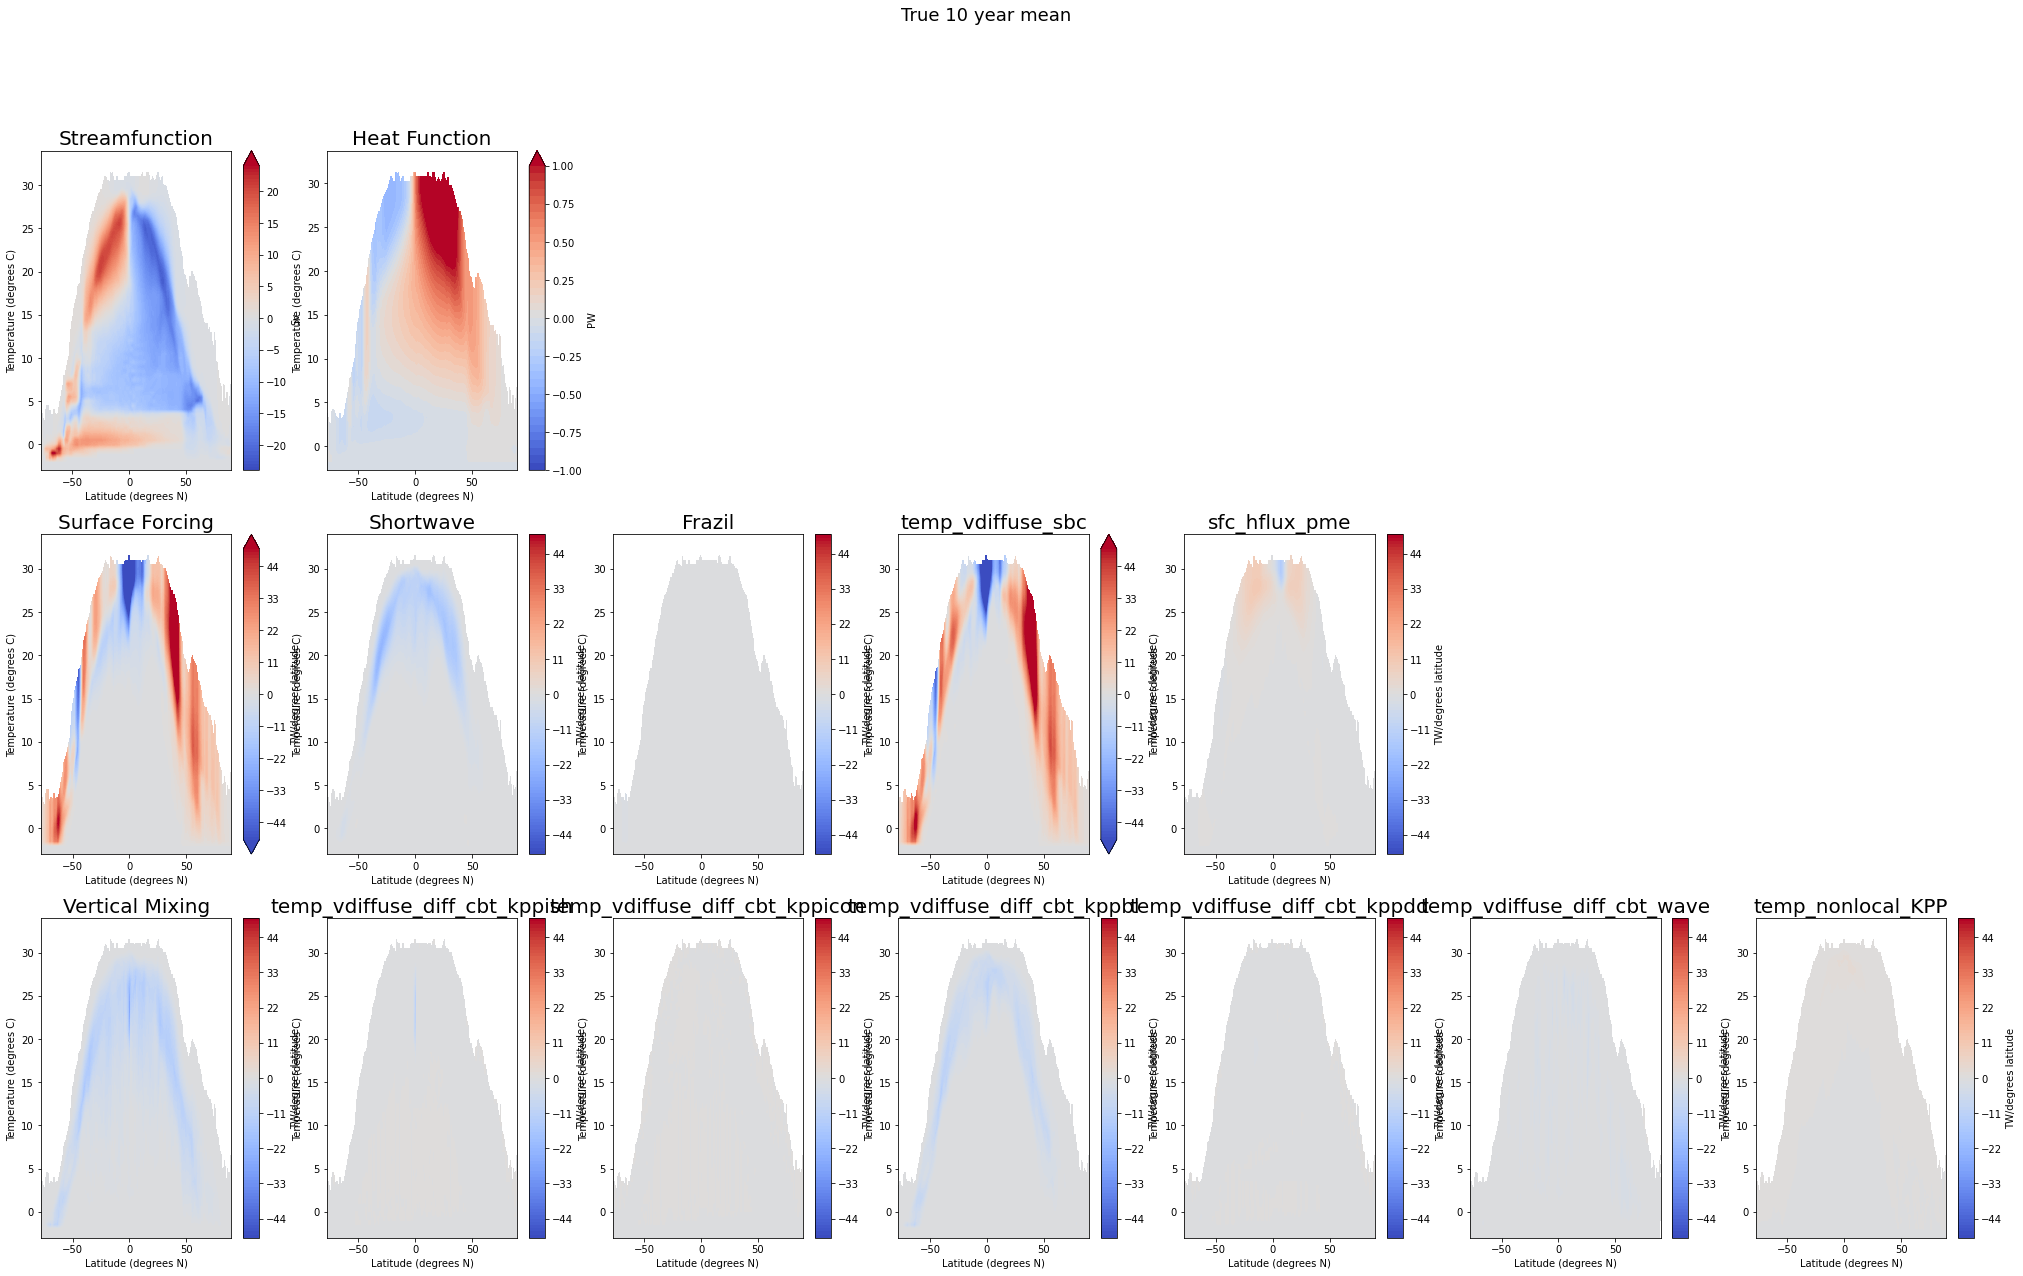

In [9]:
DataSet = True_10year_means
# masking:
maskPsi = 0*True_10year_means.Psi.sum('grid_xt_ocean').where(True_10year_means.Psi.sum('grid_xt_ocean')!=True_10year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)/2
plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'True 10 year mean')

### Load 10 year mean (mean_tot)

In [47]:
%%time

Psi_mean_tot.load()
SF_mean_tot.load()
MX_mean_tot.load()

sw_heat_mean_tot.load()
frazil_3d_mean_tot.load()
temp_vdiffuse_sbc_mean_tot.load()
sfc_hflux_pme_mean_tot.load()
temp_nonlocal_KPP_mean_tot.load()
temp_vdiffuse_diff_cbt_kppish_mean_tot.load()
temp_vdiffuse_diff_cbt_kppicon_mean_tot.load()
temp_vdiffuse_diff_cbt_kppbl_mean_tot.load()
temp_vdiffuse_diff_cbt_kppdd_mean_tot.load()
temp_vdiffuse_diff_cbt_wave_mean_tot.load()

CPU times: user 5.52 s, sys: 1.68 s, total: 7.2 s
Wall time: 19.4 s


<xarray.DataArray 'concatenate-f65233366bff577614ab0bcdf1d7f4b8' (
                                                                  grid_yt_ocean: 300,
                                                                  grid_xt_ocean: 360,
                                                                  neutralrho_edges: 75)>
array([[[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
...
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]])
Coordinates:
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0

In [48]:
ds = xr.Dataset({'Psi': Psi_mean_tot, 'SF': SF_mean_tot, 'MX': MX_mean_tot, 'sw_heat':sw_heat_mean_tot, 'frazil_3d':frazil_3d_mean_tot, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_mean_tot,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_mean_tot,
                'sfc_hflux_pme':sfc_hflux_pme_mean_tot,'temp_nonlocal_KPP':temp_nonlocal_KPP_mean_tot,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_mean_tot, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_mean_tot,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_mean_tot,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_mean_tot})
ds.to_netcdf('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/Mean_10year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [49]:
Mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/Mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

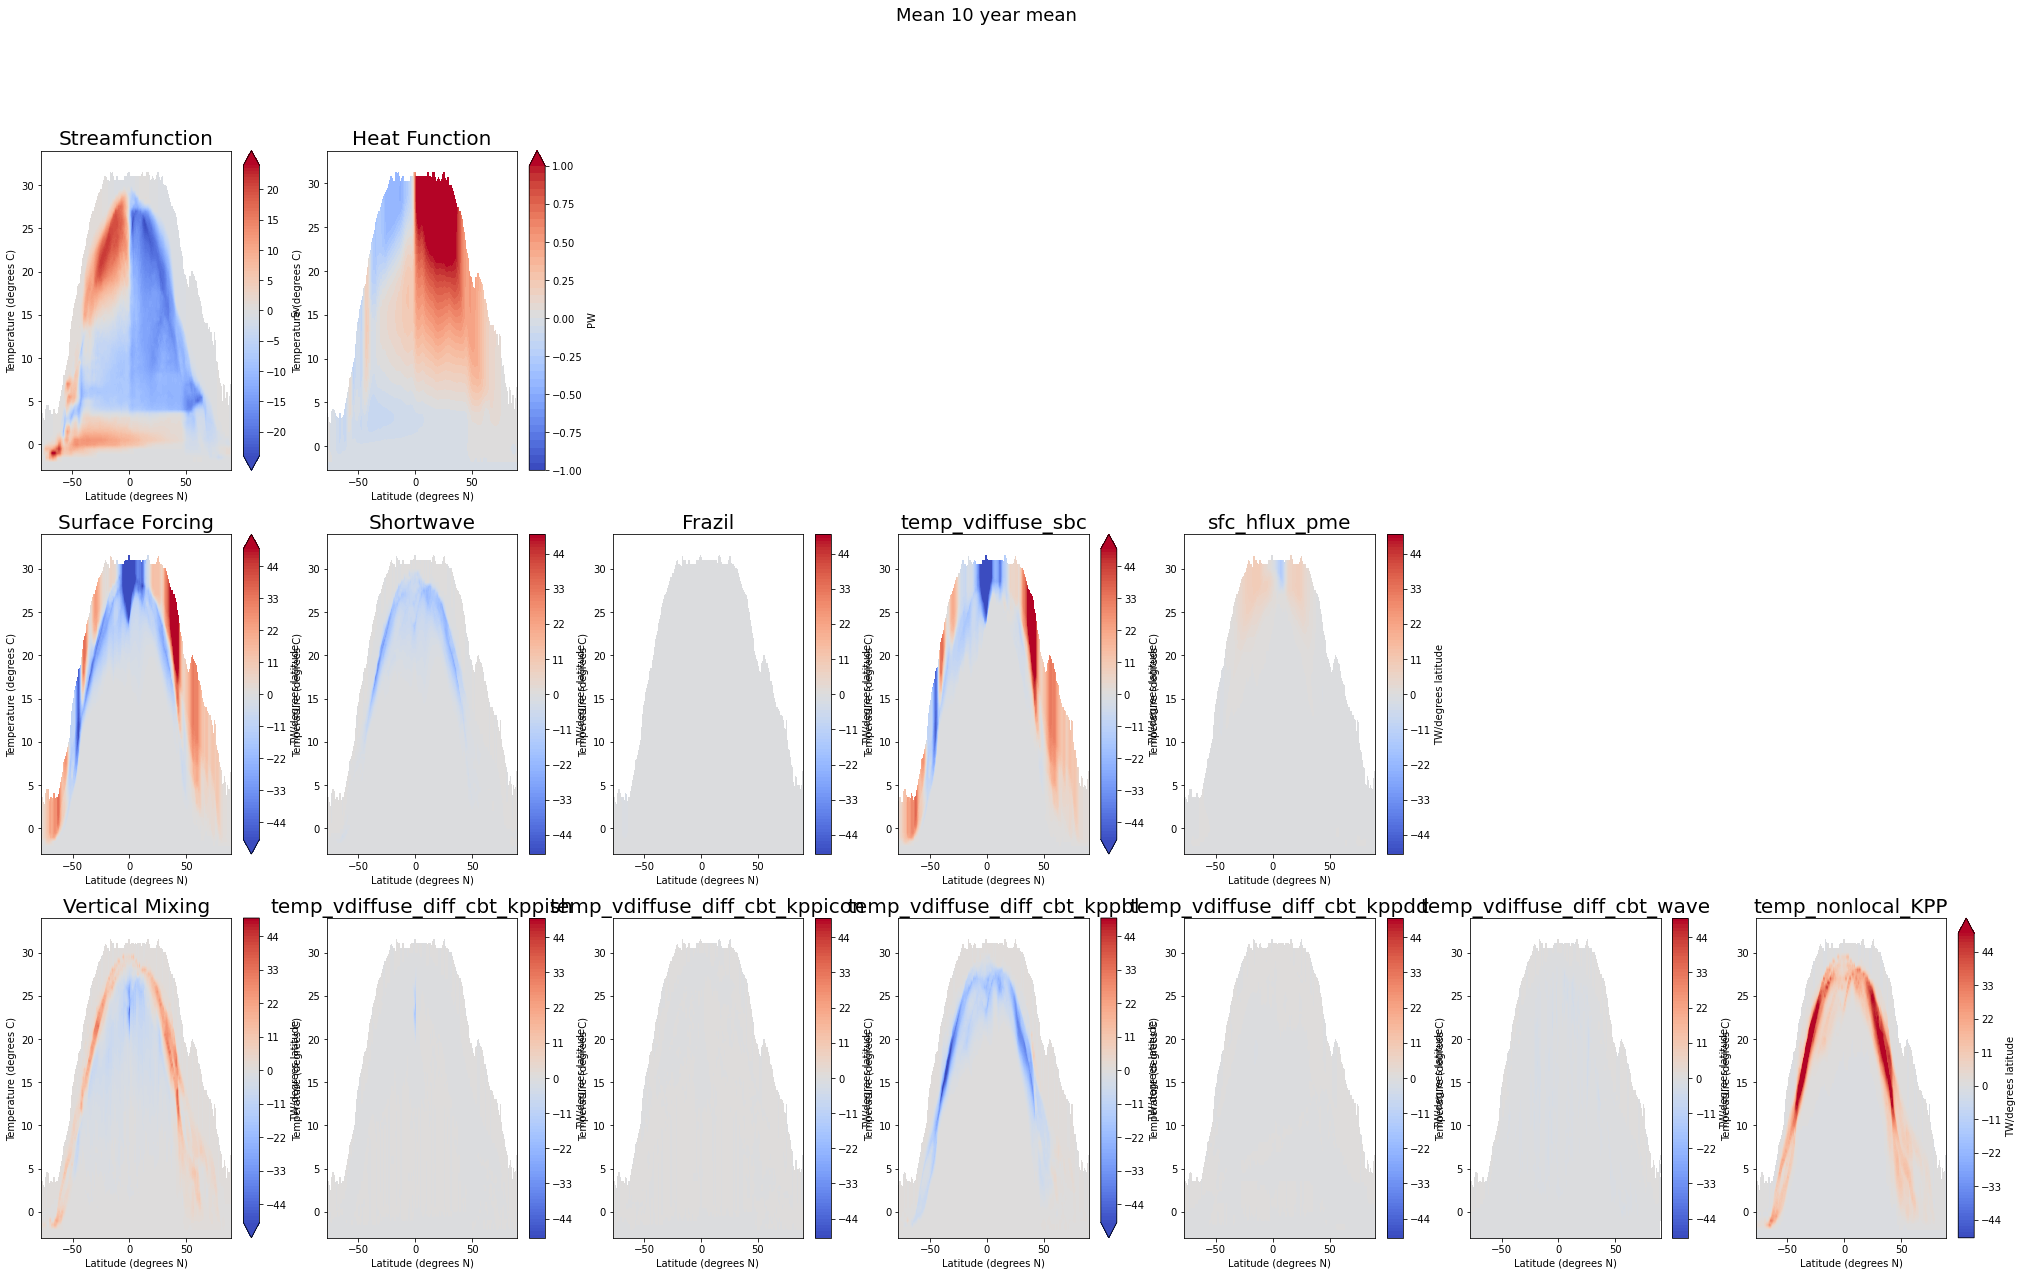

In [50]:
DataSet = Mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)


Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Mean 10 year mean')

### Load seasonal climatology 2 month running mean

In [55]:
Psi_mean_sc = weighted_time_mean_2mo_filter(Psi_mean_sc)
SF_mean_sc = weighted_time_mean_2mo_filter(SF_mean_sc)
MX_mean_sc = weighted_time_mean_2mo_filter(MX_mean_sc)

sw_heat_mean_sc = weighted_time_mean_2mo_filter(sw_heat_mean_sc)
frazil_3d_mean_sc = weighted_time_mean_2mo_filter(frazil_3d_mean_sc)
temp_vdiffuse_sbc_mean_sc = weighted_time_mean_2mo_filter(temp_vdiffuse_sbc_mean_sc)
sfc_hflux_pme_mean_sc= weighted_time_mean_2mo_filter(sfc_hflux_pme_mean_sc)
temp_nonlocal_KPP_mean_sc= weighted_time_mean_2mo_filter(temp_nonlocal_KPP_mean_sc)

temp_vdiffuse_diff_cbt_kppish_mean_sc = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppish_mean_sc)
temp_vdiffuse_diff_cbt_kppicon_mean_sc = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppicon_mean_sc)
temp_vdiffuse_diff_cbt_kppbl_mean_sc = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppbl_mean_sc)
temp_vdiffuse_diff_cbt_kppdd_mean_sc = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppdd_mean_sc)
temp_vdiffuse_diff_cbt_wave_mean_sc = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_wave_mean_sc)

In [56]:
%%time

Psi_mean_sc.load()
SF_mean_sc.load()
MX_mean_sc.load()

sw_heat_mean_sc.load()
frazil_3d_mean_sc.load()
temp_vdiffuse_sbc_mean_sc.load()
sfc_hflux_pme_mean_sc.load()
temp_nonlocal_KPP_mean_sc.load()

temp_vdiffuse_diff_cbt_kppish_mean_sc.load()
temp_vdiffuse_diff_cbt_kppicon_mean_sc.load()
temp_vdiffuse_diff_cbt_kppbl_mean_sc.load()
temp_vdiffuse_diff_cbt_kppdd_mean_sc.load()
temp_vdiffuse_diff_cbt_wave_mean_sc.load()

CPU times: user 36 s, sys: 5.57 s, total: 41.6 s
Wall time: 3min 10s


<xarray.DataArray (grid_yt_ocean: 300, grid_xt_ocean: 360, neutralrho_edges: 75)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0

In [57]:
ds = xr.Dataset({'Psi': Psi_mean_sc, 'SF': SF_mean_sc, 'MX': MX_mean_sc, 'sw_heat':sw_heat_mean_sc, 'frazil_3d':frazil_3d_mean_sc, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_mean_sc,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_mean_sc,
                 'sfc_hflux_pme':sfc_hflux_pme_mean_sc,'temp_nonlocal_KPP':temp_nonlocal_KPP_mean_sc,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_mean_sc, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_mean_sc,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_mean_sc,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_mean_sc})
ds.to_netcdf('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/sc_2mo_mean_10year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [10]:
sc_Twomo_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/sc_2mo_mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

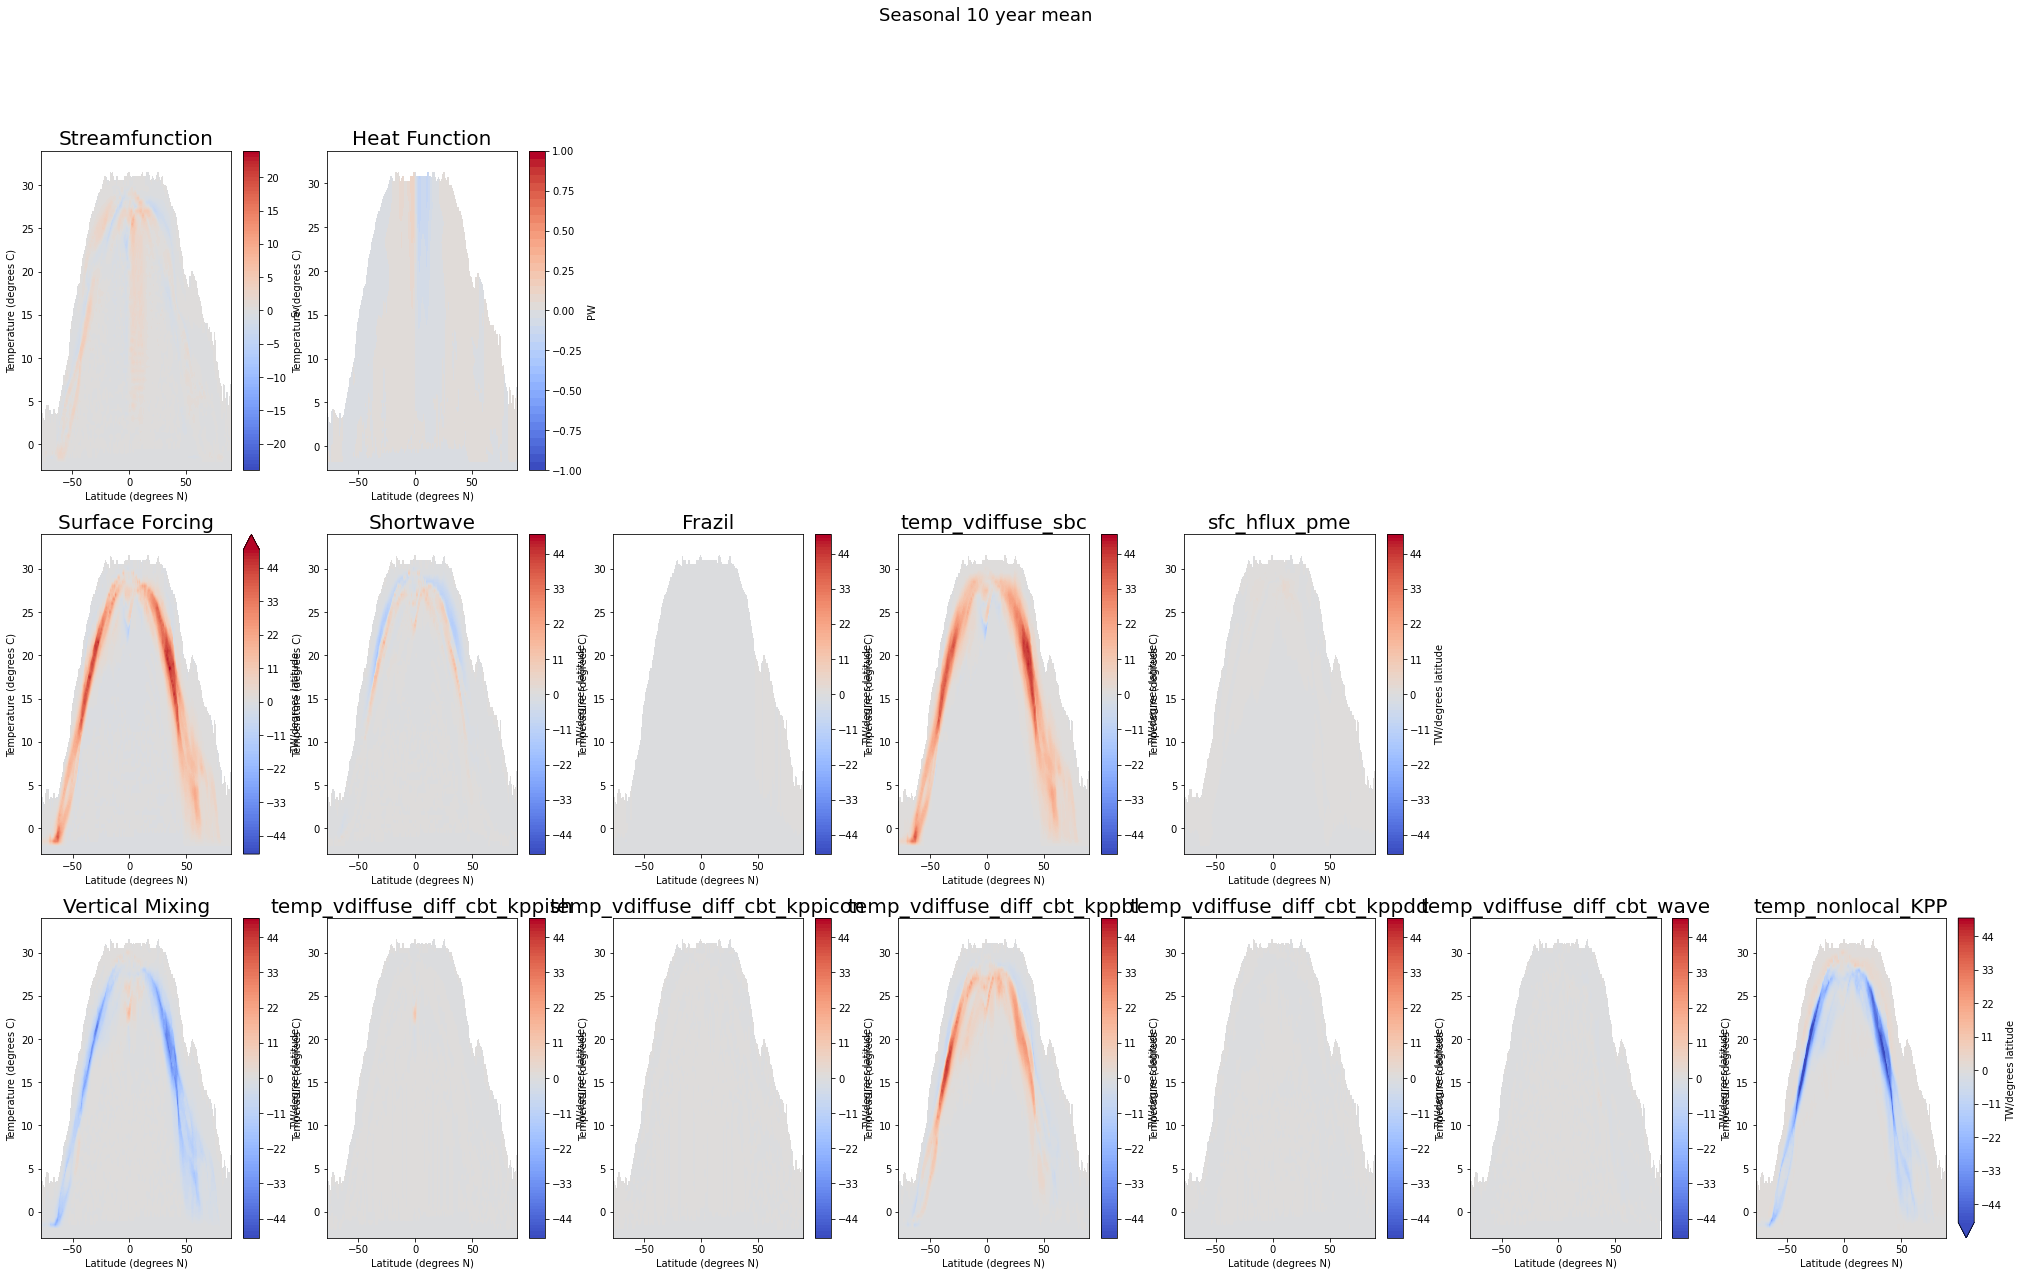

In [59]:
DataSet = sc_Twomo_mean_10year_means - Mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Seasonal 10 year mean')

### Load 2 month running mean quantities


In [ ]:
%%time

for j in np.arange(3):
    daily_array = [Psi_mean_2mo, SF_mean_2mo, MX_mean_2mo, sw_heat_mean_2mo, frazil_3d_mean_2mo, \
                   temp_nonlocal_KPP_mean_2mo, sfc_hflux_pme_mean_2mo, \
                   temp_vdiffuse_sbc_mean_2mo, temp_vdiffuse_diff_cbt_kppish_mean_2mo , \
                   temp_vdiffuse_diff_cbt_kppicon_mean_2mo, temp_vdiffuse_diff_cbt_kppbl_mean_2mo, \
                   temp_vdiffuse_diff_cbt_kppdd_mean_2mo, temp_vdiffuse_diff_cbt_wave_mean_2mo][j]
    daily_array_name = ['Psi_mean_2mo', 'SF_2mo', 'MX_2mo', 'sw_heat_2mo', 'frazil_3d_2mo', \
                        'temp_nonlocal_KPP_2mo','sfc_hflux_pme_2mo', \
                        'temp_vdiffuse_sbc_2mo','temp_vdiffuse_diff_cbt_kppish_2mo', \
                        'temp_vdiffuse_diff_cbt_kppicon_2mo', 'temp_vdiffuse_diff_cbt_kppbl_2mo', \
                        'temp_vdiffuse_diff_cbt_kppdd_2mo', 'temp_vdiffuse_diff_cbt_wave_2mo'][j]
    
    daily_array_timemean = weighted_time_mean_2mo_filter(daily_array)
    daily_array_timemean.load()

    ds = xr.Dataset({daily_array_name: daily_array_timemean})
    ds.to_netcdf('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/2mo_mean_10year_means_'+daily_array_name+'.nc', 
                 encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})


2022-12-03 17:17:47,417 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-03 17:18:00,632 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-03 17:19:09,157 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [11]:
# load from PBS script output
path = '/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/'
Psi_mean_2mo = xr.open_dataset(path+'2mo_mean_10year_means_Psi_mean_2mo.nc').Psi_mean_2mo
SF_2mo = xr.open_dataset(path+'2mo_mean_10year_means_SF_2mo.nc').SF_2mo
MX_2mo = xr.open_dataset(path+'2mo_mean_10year_means_MX_2mo.nc').MX_2mo
# sw_heat_2mo    = xr.open_dataset(path+'2mo_mean_10year_means_sw_heat_2mo.nc').sw_heat_2mo
# frazil_3d_2mo    = xr.open_dataset(path+'2mo_mean_10year_means_frazil_3d_2mo.nc').frazil_3d_2mo
# temp_vdiffuse_sbc_2mo    = xr.open_dataset(path+'2mo_mean_10year_means_temp_vdiffuse_sbc_2mo.nc').temp_vdiffuse_sbc_2mo
# sfc_hflux_pme_2mo    = xr.open_dataset(path+'2mo_mean_10year_means_sfc_hflux_pme_2mo.nc').sfc_hflux_pme_2mo
# temp_nonlocal_KPP_2mo    = xr.open_dataset(path+'2mo_mean_10year_means_temp_nonlocal_KPP_2mo.nc').temp_nonlocal_KPP_2mo
# temp_vdiffuse_diff_cbt_kppish_2mo = xr.open_dataset(path+'2mo_mean_10year_means_temp_vdiffuse_diff_cbt_kppish_2mo.nc').temp_vdiffuse_diff_cbt_kppish_2mo 
# temp_vdiffuse_diff_cbt_kppicon_2mo= xr.open_dataset(path+'2mo_mean_10year_means_temp_vdiffuse_diff_cbt_kppicon_2mo.nc').temp_vdiffuse_diff_cbt_kppicon_2mo
# temp_vdiffuse_diff_cbt_kppbl_2mo= xr.open_dataset(path+'2mo_mean_10year_means_temp_vdiffuse_diff_cbt_kppbl_2mo.nc').temp_vdiffuse_diff_cbt_kppbl_2mo
# temp_vdiffuse_diff_cbt_kppdd_2mo= xr.open_dataset(path+'2mo_mean_10year_means_temp_vdiffuse_diff_cbt_kppdd_2mo.nc').temp_vdiffuse_diff_cbt_kppdd_2mo
# temp_vdiffuse_diff_cbt_wave_2mo= xr.open_dataset(path+'2mo_mean_10year_means_temp_vdiffuse_diff_cbt_wave_2mo.nc').temp_vdiffuse_diff_cbt_wave_2mo


In [12]:
# save to one array
ds = xr.Dataset({'Psi': Psi_mean_2mo, 'SF': SF_2mo, 'MX': MX_2mo, #'sw_heat':sw_heat_2mo, 'frazil_3d':frazil_3d_2mo, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_2mo,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_2mo,
                #  'sfc_hflux_pme':sfc_hflux_pme_2mo,'temp_nonlocal_KPP':temp_nonlocal_KPP_2mo,
                # 'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_2mo, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_2mo,
                # 'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_2mo,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_2mo
                })
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101-110/2mo_mean_10year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  # 'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}
                  })

In [13]:
Twomo_mean_10year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101-110/2mo_mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})


In [14]:
def plot_decomp_3d_to_2d_short(DataSet, Psicbar, Hfcbar, MXcbar, title):
    
    plt.figure(figsize=(16,4),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    cmap = 'coolwarm'

    plt.subplot(1,4,1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title('Streamfunction', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(1,4,2)
    (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title('Heat Function', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(1,4,3)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
   
    plt.subplot(1,4,4)
    ((DataSet.MX).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

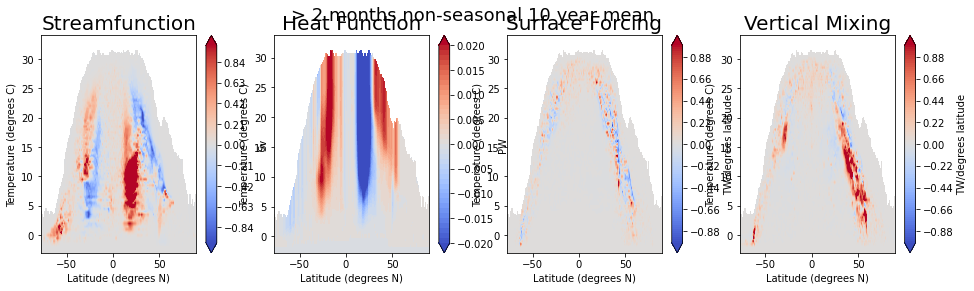

In [16]:
DataSet = Twomo_mean_10year_means - sc_Twomo_mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)/5
Hfcbar = np.arange(-0.1,0.105,0.005)/5
SFcbar = np.arange(-5.,5.1,0.1)/5
MXcbar = np.arange(-2.5,2.51,0.1)/5

cmap = 'coolwarm'

plot_decomp_3d_to_2d_short(DataSet, Psicbar, Hfcbar, MXcbar, '> 2 months non-seasonal 10 year mean')

## Daily data: Use PBS scripts similarly to 0.25 degree

Except can do without months - just split into years.

```
#!/bin/bash
#PBS -P e14
#PBS -q normalbw
#PBS -l mem=120gb,ncpus=8,walltime=0:15:00,storage=gdata/ik11+gdata/hh5+gdata/x77+gdata/e14+scratch/e14,jobfs=100gb
#PBS -N save_daily_binned_heat_terms_monthly_looped
#PBS -v year,var,mo,time
#PBS -j oe

module use /g/data3/hh5/public/modules
module unload conda
module load conda/analysis3-22.07

cd  /g/data/e14/cy8964/analysis/scripts/
# set max number of time loops to run:
n_loops=12
script_dir=/g/data/e14/cy8964/analysis/scripts
echo "submitting month $count to gadi"

# call python
python3 save_10daily_quantities_xhistogram_1deg.py $year $var $mo $time  #&>> output_save_10daily_quantities_xhistogram_10yr_year${year}_var${var}_mo${mo}_time${time}.txt


exit
```

then run with

```
#!/bin/bash

## loop over count, submit job to gadi with count that gets communicated to python

#for i in {0..11}
#do
   #echo "creating job $i"
   #qsub -v year=105,var=0,mo=${i},time=1 run_save_10daily_quantities_10yr.sh
#done

for i in {101..110}
do
   echo "creating job for year $i"
   qsub -v year=i,var=0,mo=0,time=10 run_save_10daily_quantities_10yr_loop_1deg.sh 
   qsub -v year=i,var=1,mo=0,time=10 run_save_10daily_quantities_10yr_loop_1deg.sh 
   qsub -v year=i,var=2,mo=0,time=10 run_save_10daily_quantities_10yr_loop_1deg.sh 
   qsub -v year=i,var=0,mo=0,time=1 run_save_10daily_quantities_10yr_loop_1deg.sh 
   qsub -v year=i,var=1,mo=0,time=1 run_save_10daily_quantities_10yr_loop_1deg.sh 
   qsub -v year=i,var=2,mo=0,time=1 run_save_10daily_quantities_10yr_loop_1deg.sh 
done
```

### ACTUAL CODE
```
"""
Saves 10 daily quantities for one year of 1deg JRA55 output (output given)
"""

# Load modules

# Standard modules
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram
import climtas.nci

if __name__ == '__main__':

    climtas.nci.GadiClient()
    # Start a dask cluster with multiple cores
    #worker_dir=os.getenv('PBS_JOBFS')
    #if not worker_dir:
    #        worker_dir=os.getenv('TMPDIR')
    #if not worker_dir:
    #        worker_dir="/tmp"
    #client = Client(n_workers = 8, local_dir=worker_dir)
    #client = Client(n_workers=8, local_directory='/scratch/e14/cy8964/dask_dump/dask_worker_space')
    #### get run count argument that was passed to python script ####
    import sys
    year = int(sys.argv[1])
    run_count = int(sys.argv[2])
    run_count2 = int(sys.argv[3])
    ten_or_one_day = int(sys.argv[4])

    output = 'output'+str(year).zfill(3) +'/'

    # files:
    base = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/'+output;
    xch = 360*10#2*288
    ych = 240*10#2*216

    fgrd   = xr.open_dataset(base + 'ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
    # load RYF daily data
    base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/'+output
    # ---------------------------------------------------------------------------------- #
    # load in data set ----------------------------------------------------------------- #
    fdaily = xr.open_mfdataset(base_msc+'ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
    fheat_daily = xr.open_mfdataset(base_msc+'ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
    fwmass_daily = xr.open_mfdataset(base_msc+'ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

    # ---------------------------------------------------------------------------------- #

    # Generate xgcm grid object:
    gridwm = Grid(fwmass_daily,coords={"x":{"center":"grid_xt_ocean"},
                                 "y":{"center":"grid_yt_ocean"},
                                 "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
    gridmn = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                                 "y":{"center":"yt_ocean","right":"yu_ocean"},
                                 "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
    gridht = Grid(fheat_daily,coords={"x":{"center":"xt_ocean"},
                                 "y":{"center":"yt_ocean"},
                                 "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
    gridd = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                                 "y":{"center":"yt_ocean","right":"yu_ocean"},
                                 "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

    # ---------------------------------------------------------------------------------- #

    # Some constants:
    Cp = 3992.10322329649
    rho0 = 1035
    dT = (fwmass_daily.neutral[1]-fwmass_daily.neutral[0]).values

    sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})

    def running_av_10days(variable):
        running_mean = (variable).roll(time = 1, roll_coords = False)+ (variable) + (variable).roll(time = 2, roll_coords = False)+ (variable).roll(time = 3, roll_coords = False)+(variable).roll(time = 4, roll_coords = False)+(variable).roll(time = 5, roll_coords = False)+(variable).roll(time = 6, roll_coords = False)+(variable).roll(time = 7, roll_coords = False)+(variable).roll(time = 8, roll_coords = False)+(variable).roll(time = 9, roll_coords = False)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
        running_mean = running_mean/10
        return running_mean

    obj, obj2 = xr.broadcast(fheat_daily.sfc_hflux_pme,fheat_daily.temp_vdiffuse_sbc)
    sfc_hflux_pme_daily = obj.where(fheat_daily.st_ocean==fheat_daily.st_ocean[0],other=0.)
    #fheat_daily["sfc_hflux_pme_daily"]=sfc_hflux_pme_daily
    # obj, obj2 = xr.broadcast(fdaily.pme_river,fheat_daily.temp_vdiffuse_sbc)
    # pme_river_daily = obj.where(fheat_daily.st_ocean==fheat_daily.st_ocean[0],other=0.)
    # fheat_daily["pme_river_daily"]=pme_river_daily

    MX_cv = fheat_daily.temp_vdiffuse_diff_cbt + \
                          fheat_daily.temp_nonlocal_KPP 
    SF_cv = fheat_daily.temp_vdiffuse_sbc + \
                          fheat_daily.sw_heat + \
                          fheat_daily.frazil_3d + \
                          sfc_hflux_pme_daily 


    # define bin edges
    tbins = fwmass_daily.neutralrho_edges.values

    # Calculate 10 day means
    #fwmass_daily['ty_trans_nrho_10day']= running_av_10days(fwmass_daily.ty_trans_nrho)
    temp_10day = running_av_10days(fdaily.temp)
    ty_trans_10day = running_av_10days(fdaily.ty_trans)

    # temperature binning of 10daily
    temp_u_10daily = gridd.interp(temp_10day,'y',boundary='extend')-273.15
    ty_trans_nrho_mean_10day = histogram(temp_u_10daily, bins=[tbins], dim = ['st_ocean'],weights=ty_trans_10day).rename({temp_u_10daily.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

    # temperature binning of 1daily
    temp_u_daily = gridd.interp(fdaily.temp,'y',boundary='extend')-273.15
    ty_trans_nrho_mean_1day = histogram(temp_u_daily, bins=[tbins], dim = ['st_ocean'],weights=fdaily.ty_trans).rename({temp_u_daily.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

    ##10 day means

    SF_cv_10day = running_av_10days(SF_cv)
    MX_cv_10day = running_av_10days(MX_cv)

    # fheat_daily['pme_river_10day'] = running_av_10days(fheat_daily.pme_river_daily)
    # fheat_daily['temp_rivermix_10day'] = running_av_10days(fheat_daily.temp_rivermix)

    # fheat_daily['sw_heat_10day'] = running_av_10days(fheat_daily.sw_heat)
    # fheat_daily['frazil_3d_10day'] = running_av_10days(fheat_daily.frazil_3d)
    # fheat_daily['temp_vdiffuse_sbc_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_sbc)
    # fheat_daily['sfc_hflux_pme_10day'] = running_av_10days(fheat_daily.sfc_hflux_pme_daily)
    temp_nonlocal_KPP_10day = running_av_10days(fheat_daily.temp_nonlocal_KPP)
    temp_vdiffuse_diff_cbt_kppish_10day = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppish)
    # fheat_daily['temp_vdiffuse_diff_cbt_kppicon_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppicon)
    temp_vdiffuse_diff_cbt_kppbl_10day = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppbl)
    # fheat_daily['temp_vdiffuse_diff_cbt_kppdd_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppdd)
    # fheat_daily['temp_vdiffuse_diff_cbt_wave_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_wave)


    # temperature binning of daily and 10 daily data
    # SF and MX:
    SF_cv_mean_1day = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=SF_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    MX_cv_mean_1day = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=MX_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    SF_cv_mean_10day = histogram(temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=SF_cv_10day).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    MX_cv_mean_10day = histogram(temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=MX_cv_10day).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # SF decomposition
    # fwmass_daily["sw_heat_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sw_heat).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["sw_heat_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sw_heat_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # fwmass_daily["frazil_3d_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.frazil_3d).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["frazil_3d_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.frazil_3d_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # fwmass_daily["temp_vdiffuse_sbc_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_sbc).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["temp_vdiffuse_sbc_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_sbc_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # fwmass_daily["sfc_hflux_pme_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sfc_hflux_pme_daily).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["sfc_hflux_pme_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sfc_hflux_pme_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # fwmass_daily["temp_rivermix_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_rivermix).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["temp_rivermix_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_rivermix_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # fwmass_daily["pme_river_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.pme_river_daily).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["pme_river_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.pme_river_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # MX decomposition

    temp_nonlocal_KPP_mean_1day = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_nonlocal_KPP).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    temp_nonlocal_KPP_mean_10day = histogram(temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=temp_nonlocal_KPP_10day).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


    temp_vdiffuse_diff_cbt_kppish_mean_1day = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppish).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    temp_vdiffuse_diff_cbt_kppish_mean_10day = histogram(temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=temp_vdiffuse_diff_cbt_kppish_10day).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # fwmass_daily["temp_vdiffuse_diff_cbt_kppicon_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppicon).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["temp_vdiffuse_diff_cbt_kppicon_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppicon_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    temp_vdiffuse_diff_cbt_kppbl_mean_1day = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppbl).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    temp_vdiffuse_diff_cbt_kppbl_mean_10day = histogram(temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=temp_vdiffuse_diff_cbt_kppbl_10day).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # fwmass_daily["temp_vdiffuse_diff_cbt_kppdd_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppdd).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["temp_vdiffuse_diff_cbt_kppdd_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppdd_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

    # fwmass_daily["temp_vdiffuse_diff_cbt_wave_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_wave).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
    # fwmass_daily["temp_vdiffuse_diff_cbt_wave_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_wave_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


    # # same for 1 day mean:
    SF_1day = -gridwm.cumsum((SF_cv_mean_1day*area), 'T',boundary="fill",fill_value=0)
    MX_1day = -gridwm.cumsum((MX_cv_mean_1day*area), 'T',boundary="fill",fill_value=0)

    # sw_heat_1day = -gridwm.cumsum((fwmass_daily.sw_heat_mean_1day*area), 'T',boundary="fill",fill_value=0)
    # frazil_3d_mean_1day = -gridwm.cumsum((fwmass_daily.frazil_3d_mean_1day*area), 'T',boundary="fill",fill_value=0)
    # temp_vdiffuse_sbc_mean_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_sbc_mean_1day*area), 'T',boundary="fill",fill_value=0)
    # sfc_hflux_pme_mean_1day  = -gridwm.cumsum((fwmass_daily.sfc_hflux_pme_mean_1day*area), 'T',boundary="fill",fill_value=0)
    # pme_river_mean_1day  = -gridwm.cumsum((fwmass_daily.pme_river_mean_1day*area), 'T',boundary="fill",fill_value=0)
    # temp_rivermix_mean_1day  = -gridwm.cumsum((fwmass_daily.temp_rivermix_mean_1day*area), 'T',boundary="fill",fill_value=0)
    temp_nonlocal_KPP_mean_1day  = -gridwm.cumsum((temp_nonlocal_KPP_mean_1day*area), 'T',boundary="fill",fill_value=0)
    temp_vdiffuse_diff_cbt_kppish_1day = -gridwm.cumsum((temp_vdiffuse_diff_cbt_kppish_mean_1day*area), 'T',boundary="fill",fill_value=0)
    # temp_vdiffuse_diff_cbt_kppicon_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppicon_mean_1day*area), 'T',boundary="fill",fill_value=0)
    temp_vdiffuse_diff_cbt_kppbl_1day = -gridwm.cumsum((temp_vdiffuse_diff_cbt_kppbl_mean_1day*area), 'T',boundary="fill",fill_value=0)
    # temp_vdiffuse_diff_cbt_kppdd_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppdd_mean_1day*area), 'T',boundary="fill",fill_value=0)
    # temp_vdiffuse_diff_cbt_wave_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_wave_mean_1day*area), 'T',boundary="fill",fill_value=0)


    #same for 10 day mean:
    SF_10day = -gridwm.cumsum((SF_cv_mean_10day*area), 'T',boundary="fill",fill_value=0)
    MX_10day = -gridwm.cumsum((MX_cv_mean_10day*area), 'T',boundary="fill",fill_value=0)

    # sw_heat_10day = -gridwm.cumsum((fwmass_daily.sw_heat_mean_10day*area), 'T',boundary="fill",fill_value=0)
    # frazil_3d_mean_10day = -gridwm.cumsum((fwmass_daily.frazil_3d_mean_10day*area), 'T',boundary="fill",fill_value=0)
    # temp_vdiffuse_sbc_mean_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_sbc_mean_10day*area), 'T',boundary="fill",fill_value=0)
    # sfc_hflux_pme_mean_10day  = -gridwm.cumsum((fwmass_daily.sfc_hflux_pme_mean_10day*area), 'T',boundary="fill",fill_value=0)
    # pme_river_mean_10day  = -gridwm.cumsum((fwmass_daily.pme_river_mean_10day*area), 'T',boundary="fill",fill_value=0)
    # temp_rivermix_mean_10day  = -gridwm.cumsum((fwmass_daily.temp_rivermix_mean_10day*area), 'T',boundary="fill",fill_value=0)
    temp_nonlocal_KPP_mean_10day  = -gridwm.cumsum((temp_nonlocal_KPP_mean_10day*area), 'T',boundary="fill",fill_value=0)
    temp_vdiffuse_diff_cbt_kppish_10day = -gridwm.cumsum((temp_vdiffuse_diff_cbt_kppish_mean_10day*area), 'T',boundary="fill",fill_value=0)
    # temp_vdiffuse_diff_cbt_kppicon_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppicon_mean_10day*area), 'T',boundary="fill",fill_value=0)
    temp_vdiffuse_diff_cbt_kppbl_10day = -gridwm.cumsum((temp_vdiffuse_diff_cbt_kppbl_mean_10day*area), 'T',boundary="fill",fill_value=0)
    # temp_vdiffuse_diff_cbt_kppdd_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppdd_mean_10day*area), 'T',boundary="fill",fill_value=0)
    # temp_vdiffuse_diff_cbt_wave_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_wave_mean_10day*area), 'T',boundary="fill",fill_value=0)

    # Calculate stream function for 1 yr mean transport 

    Psi_mean_10day = gridwm.cumsum(ty_trans_nrho_mean_10day, 'T',boundary="fill", fill_value=0)/rho0

    Psi_mean_1day = gridwm.cumsum(ty_trans_nrho_mean_1day, 'T',boundary="fill", fill_value=0)/rho0
    
    ## COMPUTE FOR 10 or 1 DAYS
    j = run_count ## choice of variable
    k = run_count2 ## choice of month

    if ten_or_one_day ==10:

        daily_array = [Psi_mean_10day, SF_10day, MX_10day, \
                       temp_nonlocal_KPP_mean_10day, temp_vdiffuse_diff_cbt_kppish_10day,\
                       temp_vdiffuse_diff_cbt_kppbl_10day][j]
        daily_array_name = ['Psi_mean_10day', 'SF_10day', 'MX_10day', \
                            'temp_nonlocal_KPP_10day','temp_vdiffuse_diff_cbt_kppish_10day', \
                            'temp_vdiffuse_diff_cbt_kppbl_10day'][j]

       # if k ==11:
       #     daily_array = daily_array.isel(time = np.arange(k*30,k*30+35))
       # else:
       #     daily_array = daily_array.isel(time = np.arange(k*30,k*30+30))
        daily_array_timemean = daily_array.sum('time')
        nt = len(daily_array.time.values)
        daily_array_timemean = daily_array_timemean/nt
        daily_array_timemean.load()
        ds = xr.Dataset({daily_array_name: daily_array_timemean})
        ds.to_netcdf('/g/data/e14/cy8964/Post_Process/1deg_10_year_daily_data/'+output+'10daily_mean_1year_means_'+daily_array_name+'.nc', 
                     encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})
    elif ten_or_one_day ==1:

        daily_array = [Psi_mean_1day, SF_1day, MX_1day, \
                       temp_nonlocal_KPP_mean_1day, temp_vdiffuse_diff_cbt_kppish_1day,\
                       temp_vdiffuse_diff_cbt_kppbl_1day][j]
        daily_array_name = ['Psi_mean_1day', 'SF_1day', 'MX_1day', \
                            'temp_nonlocal_KPP_1day','temp_vdiffuse_diff_cbt_kppish_1day', \
                            'temp_vdiffuse_diff_cbt_kppbl_1day'][j]

        k = run_count2
        #if k ==11:
        #    daily_array = daily_array.isel(time = np.arange(k*30,k*30+35))
        #else:
        #    daily_array = daily_array.isel(time = np.arange(k*30,k*30+30))
        daily_array_timemean = daily_array.sum('time')
        nt = len(daily_array.time.values)
        daily_array_timemean = daily_array_timemean/nt
        daily_array_timemean.load()
        ds = xr.Dataset({daily_array_name: daily_array_timemean})
        ds.to_netcdf('/g/data/e14/cy8964/Post_Process/1deg_10_year_daily_data/'+output+'1daily_mean_1year_means_'+daily_array_name+'.nc', 
                     encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})
    else: 
        print('Help, timescale not found')
```

## Combine daily files

In [ ]:
%%time

for j in np.arange(3):
    daily_array_name = ['Psi_mean_1day', 'SF_1day', 'MX_1day'][j]
    year = 101
    save_dir_begin = '/g/data/e14/cy8964/Post_Process/1deg_10_year_daily_data/output'
    output_yr = str(year).zfill(3) +'/'
    save_dir = save_dir_begin+output_yr

    term1 = xr.open_dataarray(save_dir+'1daily_mean_1year_means_'+daily_array_name+'.nc')#.daily_array_name
    term1  = xr.zeros_like(term1)
    for year in np.arange(101,111):
        print(year)
        output_yr = str(year).zfill(3) +'/'
        save_dir = save_dir_begin+output_yr
        term1_k = xr.open_dataarray(save_dir+'1daily_mean_1year_means_'+daily_array_name+'.nc')
        term1 = term1+term1_k

    term1 = term1/10
    term1.load()
    term1.sum('grid_xt_ocean').plot()
    plt.show()
    ds = xr.Dataset({daily_array_name: term1})
    ds.to_netcdf('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/'+'1daily_mean_10year_means_'+daily_array_name+'.nc', 
                 encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})


101
102
103
104
105
106
107
108
109
110


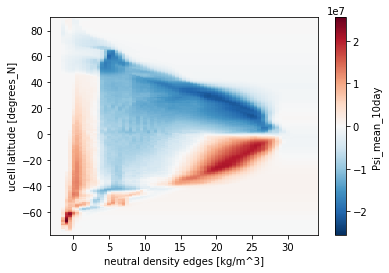

101
102
103
104
105
106
107
108
109
110


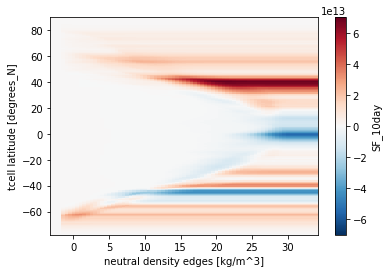

101
102
103
104
105
106
107
108
109
110


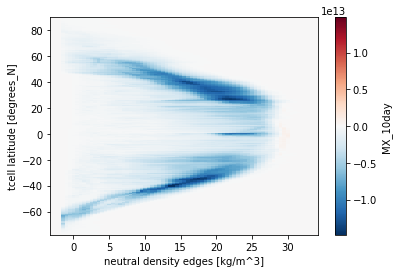

CPU times: user 13.2 s, sys: 1.75 s, total: 14.9 s
Wall time: 14.5 s


In [22]:
%%time

for j in np.arange(3):
    daily_array_name = ['Psi_mean_10day', 'SF_10day', 'MX_10day'][j]
    year = 101
    save_dir_begin = '/g/data/e14/cy8964/Post_Process/1deg_10_year_daily_data/output'
    output_yr = str(year).zfill(3) +'/'
    save_dir = save_dir_begin+output_yr

    term1 = xr.open_dataarray(save_dir+'10daily_mean_1year_means_'+daily_array_name+'.nc')#.daily_array_name
    term1  = xr.zeros_like(term1)
    for year in np.arange(101,111):
        print(year)
        output_yr = str(year).zfill(3) +'/'
        save_dir = save_dir_begin+output_yr
        term1_k = xr.open_dataarray(save_dir+'10daily_mean_1year_means_'+daily_array_name+'.nc')
        term1 = term1+term1_k

    term1 = term1/10
    term1.load()
    term1.sum('grid_xt_ocean').plot()
    plt.show()
    ds = xr.Dataset({daily_array_name: term1})
    ds.to_netcdf('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/'+'10daily_mean_10year_means_'+daily_array_name+'.nc', 
                 encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})


In [19]:
# load from PBS script output
dir_base = '/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/'
Psi_mean_1day = xr.open_dataset(dir_base+'1daily_mean_10year_means_Psi_mean_1day.nc').Psi_mean_1day
SF_1day = xr.open_dataset(dir_base+'1daily_mean_10year_means_SF_1day.nc').SF_1day
MX_1day = xr.open_dataset(dir_base+'1daily_mean_10year_means_MX_1day.nc').MX_1day
# temp_vdiffuse_diff_cbt_kppish_1day = xr.open_dataset(dir_base+'1daily_mean_10year_means_temp_vdiffuse_diff_cbt_kppish_1day.nc').temp_vdiffuse_diff_cbt_kppish_1day 
# temp_vdiffuse_diff_cbt_kppbl_1day= xr.open_dataset(dir_base+'1daily_mean_10year_means_temp_vdiffuse_diff_cbt_kppbl_1day.nc').temp_vdiffuse_diff_cbt_kppbl_1day
# temp_nonlocal_KPP_1day= xr.open_dataset(dir_base+'1daily_mean_10year_means_temp_nonlocal_KPP_1day.nc').temp_nonlocal_KPP_1day


In [20]:
# save to array
ds = xr.Dataset({'Psi': Psi_mean_1day, 'SF': SF_1day, 'MX': MX_1day,\
                # 'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_1day, \
                # 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_1day,\
                # 'temp_nonlocal_KPP':temp_nonlocal_KPP_1day
                })
ds.to_netcdf(dir_base+'1day_mean_10year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5}
                  })


In [23]:
# load from PBS script output
dir_base = '/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/'
Psi_mean_10day = xr.open_dataset(dir_base+'10daily_mean_10year_means_Psi_mean_10day.nc').Psi_mean_10day
SF_10day = xr.open_dataset(dir_base+'10daily_mean_10year_means_SF_10day.nc').SF_10day
MX_10day = xr.open_dataset(dir_base+'10daily_mean_10year_means_MX_10day.nc').MX_10day
# temp_vdiffuse_diff_cbt_kppish_10day = xr.open_dataset(dir_base+'10daily_mean_10year_means_temp_vdiffuse_diff_cbt_kppish_10day.nc').temp_vdiffuse_diff_cbt_kppish_10day 
# temp_vdiffuse_diff_cbt_kppbl_10day= xr.open_dataset(dir_base+'10daily_mean_10year_means_temp_vdiffuse_diff_cbt_kppbl_10day.nc').temp_vdiffuse_diff_cbt_kppbl_10day
# temp_nonlocal_KPP_10day= xr.open_dataset(dir_base+'10daily_mean_10year_means_temp_nonlocal_KPP_10day.nc').temp_nonlocal_KPP_10day


In [24]:
# save to array
ds = xr.Dataset({'Psi': Psi_mean_10day, 'SF': SF_10day, 'MX': MX_10day,\
                # 'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_10day, \
                # 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_10day,\
                # 'temp_nonlocal_KPP':temp_nonlocal_KPP_10day
                })
ds.to_netcdf(dir_base+'10day_mean_10year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  # 'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5}
                  })


In [26]:
Tenday_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/10day_mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
Oneday_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/1deg_101-110/1day_mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})


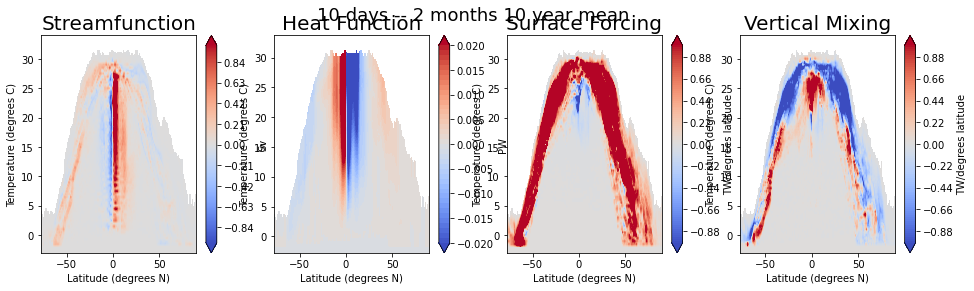

In [27]:
DataSet = Tenday_mean_10year_means - Twomo_mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)/5
Hfcbar = np.arange(-0.1,0.105,0.005)/5
SFcbar = np.arange(-5.,5.1,0.1)/5
MXcbar = np.arange(-2.5,2.51,0.1)/5

cmap = 'coolwarm'

plot_decomp_3d_to_2d_short(DataSet, Psicbar, Hfcbar, MXcbar, '10 days -- 2 months 10 year mean')

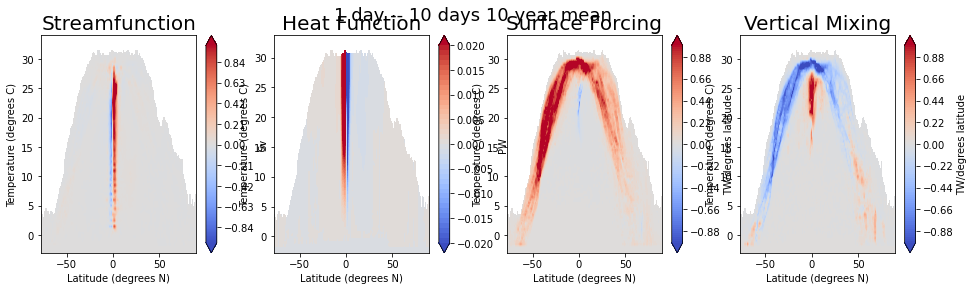

In [28]:
DataSet = Oneday_mean_10year_means - Tenday_mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)/5
Hfcbar = np.arange(-0.1,0.105,0.005)/5
SFcbar = np.arange(-5.,5.1,0.1)/5
MXcbar = np.arange(-2.5,2.51,0.1)/5

cmap = 'coolwarm'

plot_decomp_3d_to_2d_short(DataSet, Psicbar, Hfcbar, MXcbar, '1 day -- 10 days 10 year mean')

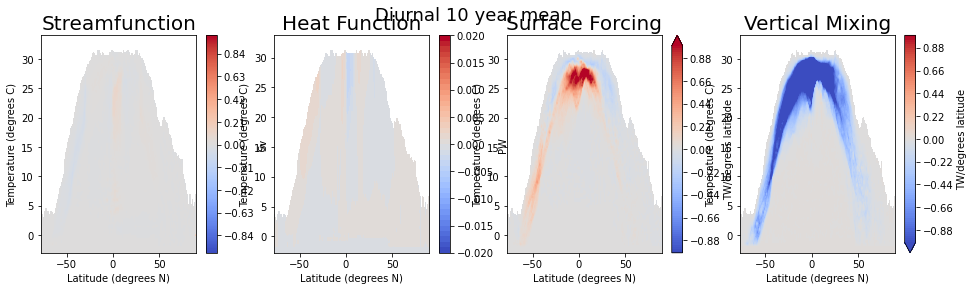

2022-12-03 18:33:55,371 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,457 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,460 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,517 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,578 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,643 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,653 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,716 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,991 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,995 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:55,998 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:56,045 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:56,133 - distributed.nanny - WARNING - Restarting worker
2022-12-03 18:33:56,295 - distributed.

In [30]:
DataSet = True_10year_means - Oneday_mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)/5
Hfcbar = np.arange(-0.1,0.105,0.005)/5
SFcbar = np.arange(-5.,5.1,0.1)/5
MXcbar = np.arange(-2.5,2.51,0.1)/5

cmap = 'coolwarm'

plot_decomp_3d_to_2d_short(DataSet, Psicbar, Hfcbar, MXcbar, 'Diurnal 10 year mean')